# BitBirch Optimal threshold

This notebook is an example on how to determine an optimal threshold for the BitBirch algorithm. It includes:
- Comparison of the distribution of similarities between fingerprints
- Comparison of the distribution of similarities between databases
- Selection of an optimal threshold based on the average and the standard deviation

Please refer to documentation for the environment setup. 

Author:
Kenneth Lopez-Perez `klopezperez@ufl.edu`

In [3]:
import bblean
import numpy as np
import bblean.similarity as iSIM
import rdkit
import matplotlib.pyplot as plt

### Fingerprint comparison

Here we will plot the pairwise similarities for carotenoid collection from obtained from COCONUT https://coconut.naturalproducts.net/collections?q= represted with ECFP4 and RDKIT fingerprints. We can notice how there is a difference of around 0.1 in the means, and how different the distributions are. Hence using the same threshold for both would not be ideal. 

Note that this step might take a while since we are doing pairwise comparisons.

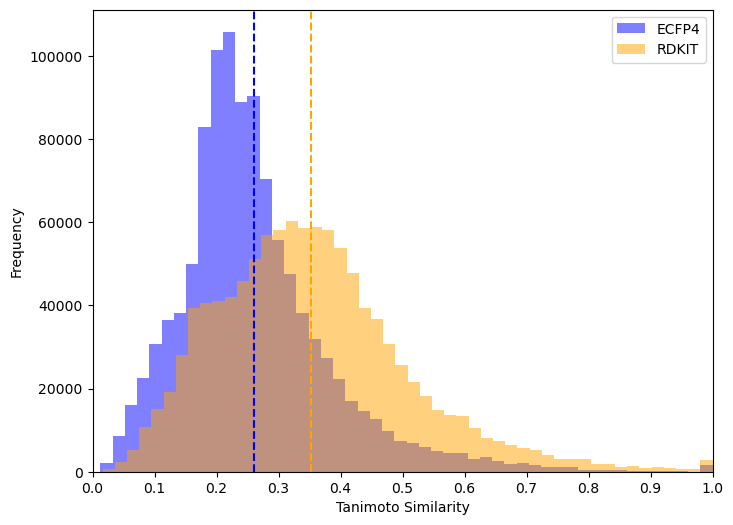

In [42]:
smiles = bblean.load_smiles('carotenoids.smi')
fps_ecfp4 = bblean.fps_from_smiles(smiles, 'ecfp4', n_features=2048)
fps_rdkit = bblean.fps_from_smiles(smiles, 'rdkit', n_features=2048)

sims_ecfp4 = iSIM.jt_sim_matrix_packed(fps_ecfp4)
sims_rdkit = iSIM.jt_sim_matrix_packed(fps_rdkit)

plt.figure(figsize=(8,6))
plt.hist(sims_ecfp4.flatten(), bins=50, alpha=0.5, label='ECFP4', color='blue')
plt.hist(sims_rdkit.flatten(), bins=50, alpha=0.5, label='RDKIT', color='orange')
plt.axvline(x=np.mean(sims_ecfp4), ymin=0, ymax=plt.ylim()[1], color='blue', linestyle='dashed')
plt.axvline(x=np.mean(sims_rdkit), ymin=0, ymax=plt.ylim()[1], color='orange', linestyle='dashed')
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distributions_by_fp.png', dpi=400)
plt.show()


### Database comparison

Now, let's compare how different the distributions are for two databases: the carotenoid we used in the first section and a random sample of the size from ChEMBL. We can see how even the difference is bigger; hence we cannot just use the same value for all databases.

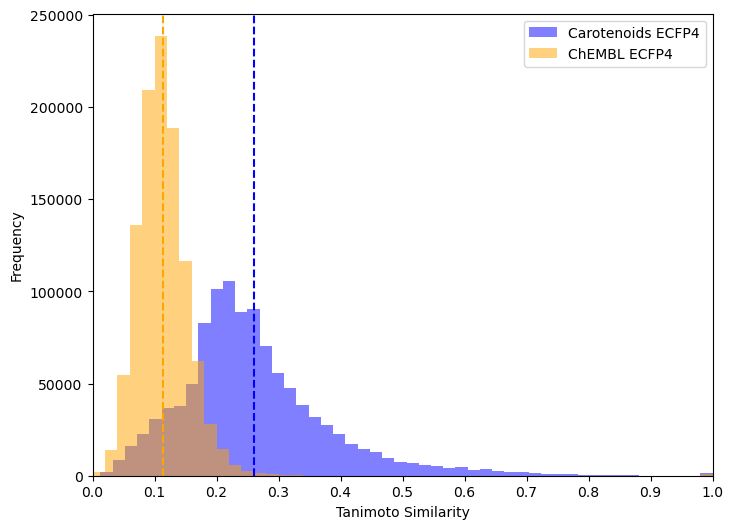

In [41]:
smiles_chembl = bblean.load_smiles('sampled_chembl.smi', max_num=len(smiles))
chembl_ecfp4 = bblean.fps_from_smiles(smiles_chembl, 'ecfp4', n_features=2048)

sims_chembl_ecfp4 = iSIM.jt_sim_matrix_packed(chembl_ecfp4)

plt.figure(figsize=(8,6))
plt.hist(sims_ecfp4.flatten(), bins=50, alpha=0.5, label='Carotenoids ECFP4', color='blue')
plt.hist(sims_chembl_ecfp4.flatten(), bins=50, alpha=0.5, label='ChEMBL ECFP4', color='orange')
plt.axvline(x=np.mean(sims_ecfp4), color='blue', linestyle='dashed')
plt.axvline(x=np.mean(sims_chembl_ecfp4), color='orange', linestyle='dashed')
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distributions_by_database.png', dpi=400)
plt.show()

In [38]:
print(f"Standard deviation Carotenoids ECFP4: {np.std(sims_ecfp4):.4f}")
print(f"Standard deviation ChEMBL ECFP4: {np.std(sims_chembl_ecfp4):.4f}")

Standard deviation Carotenoids ECFP4: 0.1235
Standard deviation ChEMBL ECFP4: 0.0476


### Selecting the optimal threshold

iSIM which is linear scaling way of calculating the average of the pairwise similarities without having to compute them. With iSIM, we can quickly obtain the average and use it as reference to select our threshold. 

For instance, for the two databases above:


In [32]:
iSIM_carotenoids = iSIM.jt_isim(fps_ecfp4)
iSIM_chembl = iSIM.jt_isim(chembl_ecfp4)

print(f"iSIM Carotenoids ECFP4: {iSIM_carotenoids:.4f}")
print(f"iSIM ChEMBL ECFP4: {iSIM_chembl:.4f}")

iSIM Carotenoids ECFP4: 0.2496
iSIM ChEMBL ECFP4: 0.1128


We can see that in the distribution of ECFP4 fingerprints using typical values of what would be consider "similar" (e.g., 0.70), would not give the best results. BitBirch uses as merging criterion the iSIM of a subcluster, hence using a value that much larger than the average (e.g., 0.11 for ChEMBL) would give an extremely large number of singletons. 

We are going to use the standard deviation of the similarities to guide the threshold selection. But we won't have to calculate all the pairwise similarities, for the estimation of the standard deviation we will use iSIM-sigma, an efficient linear scaling aproach.

The differences in standard deviations are also significant.

In [34]:
iSIM_sigma_carotenoids = iSIM.estimate_jt_std(fps_ecfp4)
iSIM_sigma_chembl = iSIM.estimate_jt_std(chembl_ecfp4)

print(f"iSIM-sigma Carotenoids ECFP4: {iSIM_sigma_carotenoids:.4f}")
print(f"iSIM-sigma ChEMBL ECFP4: {iSIM_sigma_chembl:.4f}")

iSIM-sigma Carotenoids ECFP4: 0.1260
iSIM-sigma ChEMBL ECFP4: 0.0408


Takeaway:
- The distribution of similarities can highly differ between fingeprint types and databases. 
- iSIM and iSIM-sigma can be used as reference to define a threshold for each case.

### Cluster with informed thresholds

We probably want to get away from the average for our threshold, we can follow the logic of using the standard deviation to do these steps.